During the Summer of 2015, my wife and I were delivering pizzas at the Domino's in Boise, Idaho. I *made* her collect data with me and then I manually input 1301 (deliveries) rows, 11 columns per row, of data into excel. 


![Domino's](http://www.pizzadelivery.org/Portals/0/ContentImages/xebra_dominos_store.jpg)

I've been wanting to write up a magnum opus on this data and all of the insights but I've decided it's too much to try to include in one post. I've decided to answer one question at a time, but even then, one question leads to many more.

Today's question: Is there any correlation between delivery distance from the store and tip amount/tip percentage of order?

Hypothesis: People don't take into account or/nor care about the distance a delivery driver traveled in their tipping decisions.

So my Econometrics teacher tells me that the null hypothesis is the hypothesis we hope reject. In that case:

H0: Distance's effect on Y (Tip) == 0

HA: Distance's effect on Y != 0

In [110]:
#My first step is to run an Ordinary Least Squares Regression 
#model with tips ~ distances
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import statsmodels.formula.api as sm
from statsmodels.api import add_constant
import math
from __future__ import division

data = pd.read_csv(r'C:\Users\angelddaz\OneDrive\Documents\data_training\data\RawDelData.csv') #please fix

#Querying our data!
stats = data.loc[data['OrderAmount']>-100.00][['Tip','Distance']]

#This is the model magic
lm = sm.ols(formula='Tip ~ Distance', data=stats).fit()
#Intercept:3.0295	#Distance Coefficient: 0.1588


lm.params
#Therefore, our model is: Tip = $3.03 + $0.16(Miles)

Intercept    3.029544
Distance     0.158800
dtype: float64

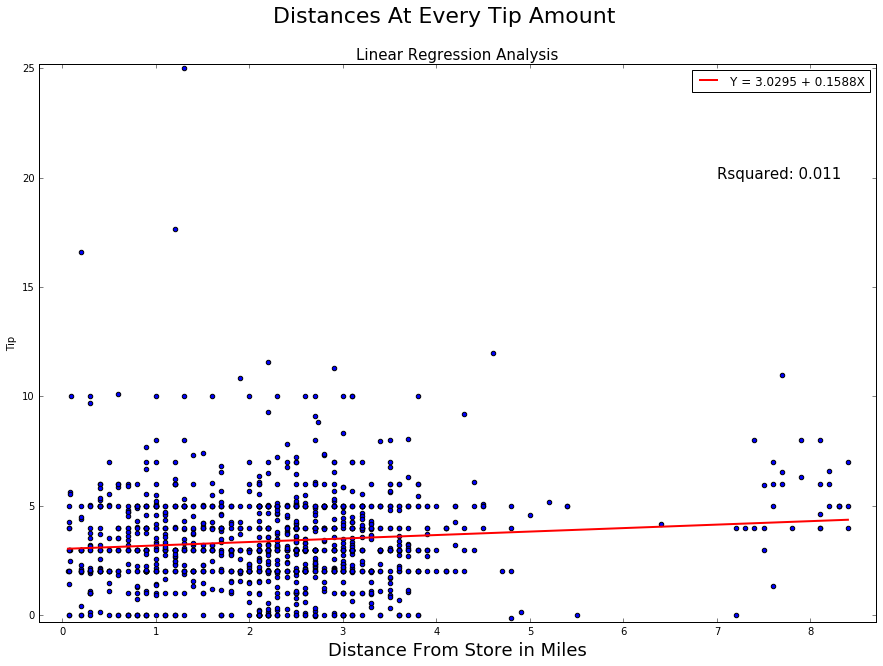

In [112]:
X_new = pd.DataFrame({'Distance': [stats.Distance.min(), stats.Distance.max()]})
X_new.head()
#making the line with our observed distances
preds = lm.predict(add_constant(X_new), transform=False)
#plotting our scatter plot
ax1 = stats.plot(kind='scatter', x='Distance', y='Tip')

#Making it pretty
ax1.text(7, 20, r'Rsquared: 0.011', fontsize=15)
pl.xlabel('Tip Amount in Dollars', fontsize=18)
pl.xlabel('Distance From Store in Miles', fontsize=18)
pl.xlim(-0.25, 8.7)
pl.ylim(-0.30, 25.2)
pl.suptitle('Distances At Every Tip Amount', fontsize=22)
pl.title('Linear Regression Analysis',fontsize=15)
pl.rcParams['figure.figsize'] = (15, 10)
#plotting our line
ax2 = pl.plot(X_new,preds, c='red', linewidth=2)
pl.legend(ax2, ('Y = 3.0295 + 0.1588X',), loc='best')


pl.show()

In [101]:
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                    Tip   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     13.97
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           0.000194
Time:                        19:11:43   Log-Likelihood:                -2816.2
No. Observations:                1301   AIC:                             5636.
Df Residuals:                    1299   BIC:                             5647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.0295      0.113     26.704      0.0

This gets me a small slope, with "passing" t-score (3.737), P-Value (0.000), and passing confidence interval at a 95% confidence level that does not include the value of 0. However, I have a terrible R-squared value with almost none of the variance in the data being accounted for by our model.

This is a case where I think we go against the model because of intimate knowledge of the data. I happen to know that a lot of far deliveries were to a richer neighborhood, Hidden Springs. 

![Hidden Springs](http://www.hiddensprings.com/Documents%20and%20Settings/5/Site%20Documents/2015/Feature/feature-1.jpg)

A well to do neighborhood tucked away in the foothills, making it one of the farthest places we delivered to. I wonder if the high tip values from Hidden Springs are skewing the model because Hidden Springs was a wealthier neighborhood than average, not because they were farther from the store?

Hmmm... ![Hand on chin Emoji](http://emojipedia-us.s3.amazonaws.com/cache/f2/d6/f2d628ebae2d60b9befa3a64107cc45d.png)

In [102]:
#First I query the data that's past 5, 6, and 7 miles to see what's going on.

far = data.loc[data['Distance']>=5.00][['Tip','Area(text)', 'Distance']]
far

,Tip,Area(text),Distance
10,4.00,Hidden Springs,7.8
29,6.00,Hidden Springs,8.1
36,7.00,Hidden Springs,8.4
57,6.56,Hidden Springs,7.7
58,6.00,Hidden Springs,8.2
84,4.00,Hidden Springs,8.1
88,8.00,Hidden Springs,7.4
92,4.60,Bogus Basin - Brumback Hills,5.0
103,4.17,Hidden Springs,6.4
107,4.62,Hidden Springs,8.1


This gives us 38 deliveries. 33 of which are Hidden Springs deliveries.
Wealthier neighborhoods tip more from analysis of the data elsewhere. I cannot claim I know exactly why they tip more but I feel comfortable enough to make the claim that Hidden Springs is not tipping more because they feel bad for making us drive out.  To support the claim that socioeconomic status of the neighborhood affects tipping rates let's look at Garden City data, which is closer to the store, poorer, and tips worse.

To build my case that Hidden Springs tips better because they're of a higher socioeconomic status, not because they're farther,
I'm going to use Garden City, an objectively poorer part of town as a contrast.

In [103]:
gcDels = data.loc[data['Area(text)']=='Garden City'][['Tip', 'Housing']]
hsDels = data.loc[data['Area(text)']=='Hidden Springs'][['Tip', 'Housing']]

On a surface level analysis, Hidden Springs does tip higher. However, this can be skewed by the low sample count in Hidden springs. There's a way to solve this problem, but before we do that... I want to break down tipping averages by housing type.

GC Houses:  75
GC Apartments:  97
GC Businesses:  32
GC Hotels:  71


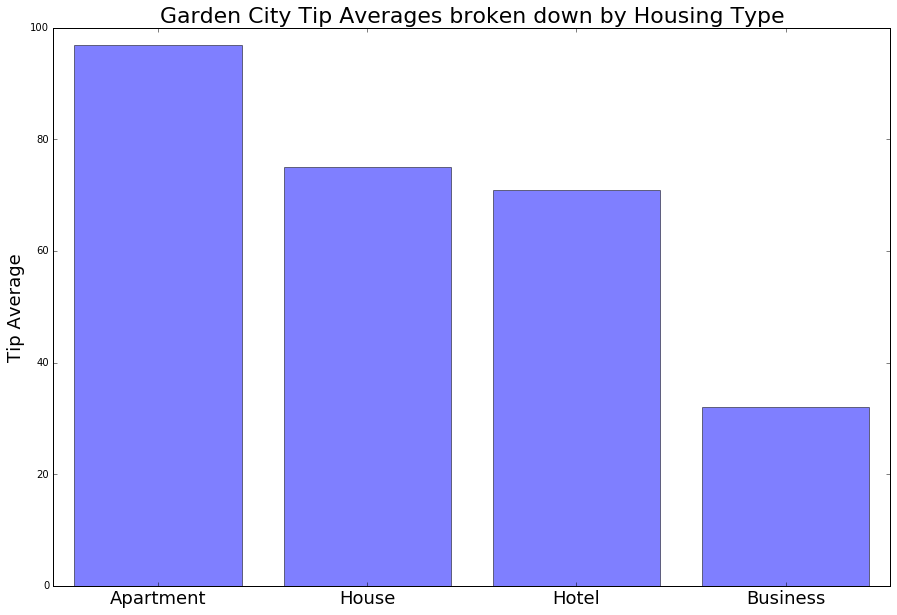

In [104]:
#Apartments, due to a lack of foresight, includes trailers.

gcDels = data.loc[data['Area(text)']=='Garden City'][['Tip', 'Housing']]
apt = 0
house = 0
business = 0
hotel = 0
for h in gcDels['Housing']:
    if h == 'Apartment':
        apt = apt + 1
    elif h == 'House':
        house = house + 1
    elif h == 'Hotel':
        hotel = house + 1
    elif h == 'Business':
        business = business + 1

print "GC Houses: ",house
print "GC Apartments: ",apt
print "GC Businesses: ",business
print "GC Hotels: ",hotel

#building a bar chart
objects = ('Apartment', 'House', 'Hotel', 'Business')
y_pos = np.arange(len(objects))
xvals = [apt, house, hotel, business]

pl.bar(y_pos, xvals, align='center', alpha=0.5)
pl.xticks(y_pos, objects, fontsize=18)
pl.ylabel('Tip Average', fontsize=18)
pl.title('Garden City Tip Averages broken down by Housing Type', fontsize=22)
pl.rcParams['figure.figsize'] = (15, 10)

In [105]:
#Now for a breakdown of housing types of the Hidden Springs neighborhood.
hsDels = data.loc[data['Area(text)']=='Hidden Springs'][['Tip', 'Housing']]

apt = 0
house = 0
business = 0
hotel = 0
for h in hsDels['Housing']:
    if h == 'Apartment':
        apt = apt + 1
    if h == 'House':
        house = house + 1
    if h == 'Hotel':
        hotel = house + 1
    if h == 'Business':
        business = business + 1

print "HS Apartments: ",apt
print "HS Houses: ",house
print "HS Businesses: ",business
print "HS Hotels: ",hotel

HS Apartments:  1
HS Houses:  33
HS Businesses:  0
HS Hotels:  0


![Another bar chart](http://i.imgur.com/KYrrHop.png)

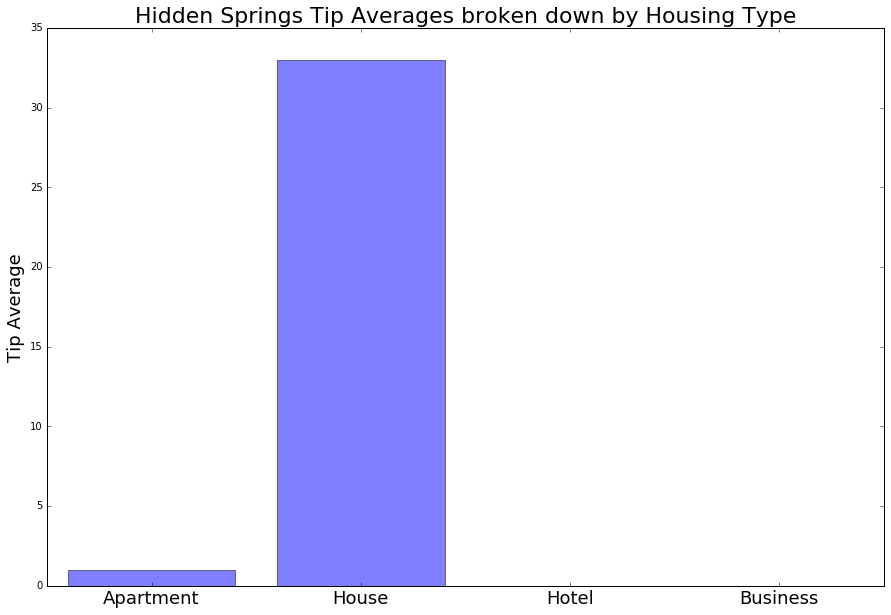

In [106]:
#building another bar chart
objects = ('Apartment', 'House', 'Hotel', 'Business')
y_pos = np.arange(len(objects))
xvals = [apt, house, hotel, business]

pl.bar(y_pos, xvals, align='center', alpha=0.5)
pl.xticks(y_pos, objects, fontsize=18)
pl.ylabel('Tip Average', fontsize=18)
pl.title('Hidden Springs Tip Averages broken down by Housing Type', fontsize=22)
pl.rcParams['figure.figsize'] = (15, 10)
pl.show()

There are more apartments/trailers in Garden City, because Garden City is a poorer neighborhood in this case, making it more likely to get higher tips. A more precise and project for later on is to scrape zillow for house prices to show this disparity even further.

For now, let's do a Difference of Two Sample means t-Test to account for our difference in sample sizes. Just to clarify; my null hypothesis for this t test is that there's no statistical difference between hidden springs and Garden City.

H0: mu(Garden City) == mu(Hidden Springs)
HA: mu(Garden City) != mu(Hidden Springs)

In [107]:
#Collecting important statistics from our two datasets that will be used in a t test later on.
mu_gc = gcDels.mean() #GC Delivery mean = 2.96
mu_hs = hsDels.mean() #HS Delivery mean = 5.24

sigma_gc = gcDels.std() #GC stdev = 2.0829
sigma_hs = hsDels.std() #HS stdev = 1.9950

variance_gc = gcDels.std() * gcDels.std() #GC variance = 4.3386
variance_hs = hsDels.std() * hsDels.std() #HS variance = 3.9799


n_gc = len(gcDels) #GC sample size = 221
n_hs = len(hsDels) #HS sample size = 34

degfreedom = n_gc + n_hs - 2 -1 #n-k-1: degrees of freedom = 252

#Two Sample T Test
den1 = variance_gc / n_gc 
den2 = variance_hs / n_hs 
den3 = den1+den2

den = math.sqrt(den3)

num = mu_gc - mu_hs    

t_stat = num/den #t stat: -6.166

t_crit = 1.9673 #95% confidence interval
print "T stat:"
print t_stat

print "\n"
from scipy import stats
print "P Val"
pval = stats.t.sf(np.abs(t_stat), degfreedom)*2
print pval

T stat:
Tip   -6.166058
dtype: float64


P Val
[  2.76587252e-09]


With a t stat of -6.166 and t critical of 1.9673, and a p-val of 0.000 we reject the null hypothesis. There is a statistically significant difference between tipping averages in Hidden Springs and Garden City! Huge difference.

So with the idea that Hidden Springs is skewing our data with the confounding variable of wealth, I will run the linear regression again to see what changes. 

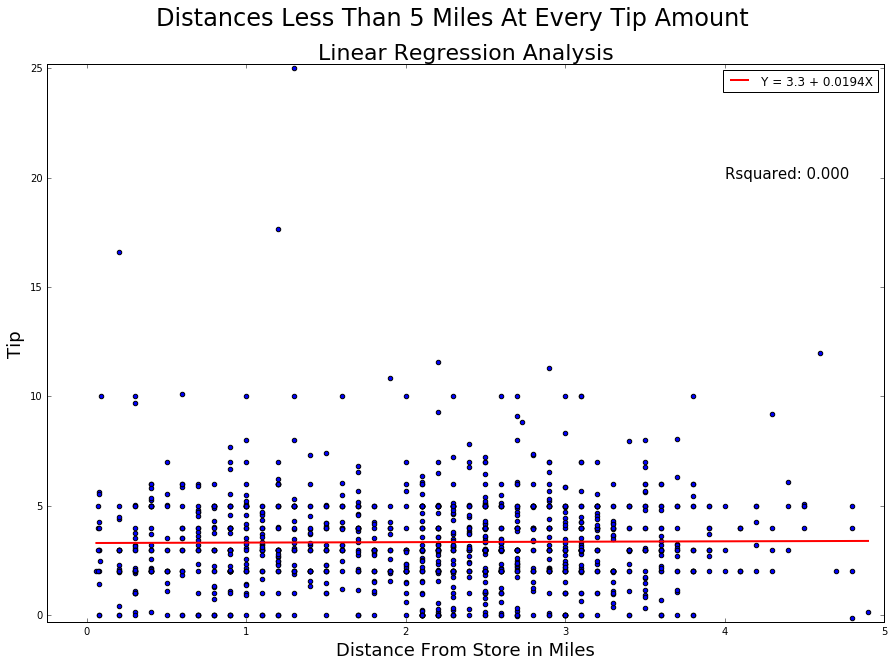

In [108]:
filtered = data.loc[data['Distance']<5.00][['Tip', 'Distance']]

lm = sm.ols(formula='Tip ~ Distance', data=filtered).fit()
lm.params     #Intercept:3.3         #OrderAmount: 0.02

X_new = pd.DataFrame({'Distance': [filtered.Distance.min(), filtered.Distance.max()]})
X_new.head()

preds = lm.predict(add_constant(X_new), transform=False)
ax1 = filtered.plot(kind='scatter', x='Distance', y='Tip')
ax1.text(4, 20, r'Rsquared: 0.000', fontsize=15)
pl.xlim(-0.25, 5)
pl.ylim(-0.30, 25.2)
pl.ylabel('Tip', fontsize=18)
pl.xlabel('Distance From Store in Miles', fontsize=18)
#pl.xticks(min(X_new), max(X_new)+0.5, 1.0)
pl.suptitle('Distances Less Than 5 Miles At Every Tip Amount', fontsize=24)
pl.title('Linear Regression Analysis',fontsize=22)

ax2 = pl.plot(X_new,preds, c='red', linewidth=2)
pl.legend(ax2, ('Y = 3.3 + 0.0194X',), loc='best')         #Need a trailing comma in legend
lm.summary()                            #so that it all displays.
pl.rcParams['figure.figsize'] = (15, 10)
pl.show()

The filtered model without the 38 farthest deliveries is now nearly flat. For every mile increased, there can be an increase of 16 cents but Rsquared is 0. Virtually no relation between distance and amount people tip.

The intercept for this model is 10 cents lower than our original regression. Just looking at the scatter plot also gives a hint that tips of every amount can be found at nearly every distance amount. That possibly could have saved us all this problem solving but this was a fun exercise!

![Customers](https://estelleryanblog.files.wordpress.com/2013/08/shrug.jpg)

Bottom line: My suspicion that customers don't know/care to tip their drivers more when the store is far away, is correct. If I was a consultant for a delivery driver that handed me this data and wanted to increase their tip averages, I would recommend: Let the customer know that you came a long way by saying something like "Oh wow, I don't come out this far very often". At this point, it can only help a rock bottom correlation between distance and tips.

![Pizza](http://www.cicis.com/media/1243/pizza_adven_zestypepperoni.png)